In [1]:
# from glob import glob
# import datetime as dt
import os
os.chdir('/g/data/vf71/la6889/lme_scale_calibration_ISMIP3a/new_workflow/')

In [2]:
import xarray as xr
import json
import pandas as pd
import numpy as np
import useful_functions as uf

In [10]:
#Up to 1960
# params = json.load(open(
#     os.path.join('/g/data/vf71/la6889/lme_scale_calibration_ISMIP3a',
#                  'data/dbpm_size_params.json')))

#Full dataset
params = json.load(open(
    os.path.join('/g/data/vf71/la6889/lme_scale_calibration_ISMIP3a/new_workflow',
                 'outputs/dbpm_size_params.json')))

In [11]:
dbpm_input = pd.read_parquet(
    os.path.join('/g/data/vf71/la6889/lme_scale_calibration_ISMIP3a/data',
                 'dbpm_clim-fish-inputs_fao-58_1841-2010.parquet'))
# dbpm_input = dbpm_input[dbpm_input.year == 1960].reset_index(drop = True)

In [12]:
%%time 
test = uf.sizemodel(params, dbpm_input)

CPU times: user 10min 30s, sys: 213 ms, total: 10min 30s
Wall time: 10min 30s


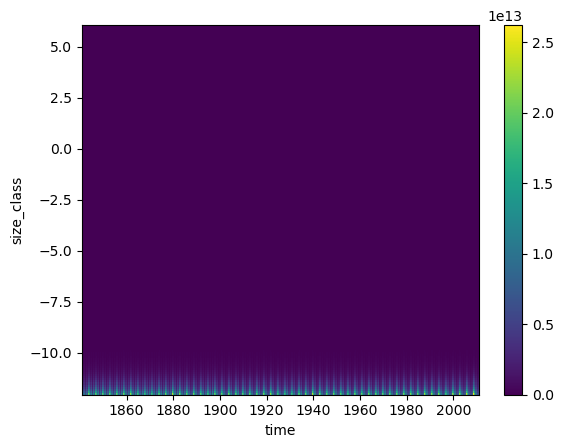

In [13]:
test['predators'].plot()

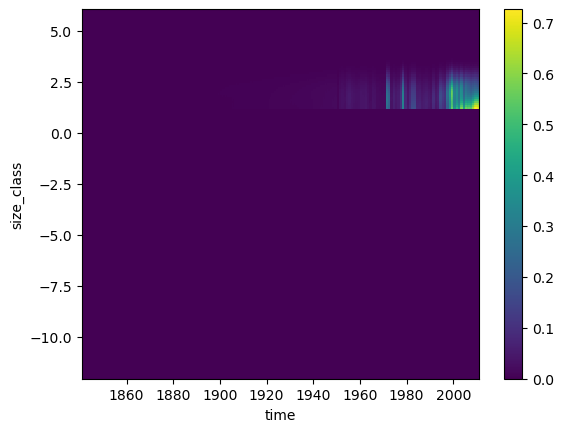

In [15]:
test['catch_pred'].plot()

## Parameters from `sizemodel` function

In [5]:
ERSEM_det_input = False
temp_effect = True
use_init = False

In [6]:
[timesteps_years] = params['timesteps_years']
[numb_size_bins] = params['numb_size_bins']
[numb_time_steps] = params['numb_time_steps']
#Index for minimum detritivore size
[ind_min_detritivore_size] = np.array(params['ind_min_detritivore_size'])-1
idx_new = np.arange(ind_min_detritivore_size+1, numb_size_bins)
#Size bin index
log10_size_bins = np.array(params['log10_size_bins'])
log10_size_bins_mat = xr.DataArray(data = log10_size_bins, 
                               dims = ['size_class'], 
                               coords = {'size_class': log10_size_bins})
size_bin_vals = 10**log10_size_bins_mat
[log_size_increase] = params['log_size_increase']
#Time
time = np.array(pd.date_range(dbpm_input.time.min()-pd.DateOffset(months = 1),
                                  dbpm_input.time.max(), freq = 'MS'),
                    dtype = 'datetime64[ns]')
dbpm_input_time = np.array(dbpm_input.time, dtype = 'datetime64[ns]')
effort = xr.DataArray(data = params['effort'], dims = 'time', 
                          coords = {'time': dbpm_input_time})
[log10_pred_prey_ratio] = params['log10_pred_prey_ratio']
[log_prey_pref] = params['log_prey_pref']
[metabolic_req_pred] = params['metabolic_req_pred']
[metabolic_req_detritivore] = params['metabolic_req_detritivore']

#Index for minimum predator size
[ind_min_pred_size] = np.array(params['ind_min_pred_size'])-1
#Index for minimum size of detritivore fished
[ind_min_fish_det] = (np.array(params['ind_min_fish_det'])-1).astype('int')
#Index for minimum size of predator fished
[ind_min_fish_pred] = (np.array(params['ind_min_fish_pred'])-1).astype('int')
#Indexes for predator density
idx = np.array(params['idx'])-1

#Sinking rate
sinking_rate = xr.DataArray(data = params['sinking_rate'], dims = 'time', 
                            coords = {'time': dbpm_input_time})

In [7]:
constant_growth = uf.gphi_f(uf.pred_prey_matrix(log10_size_bins), 
                            log10_pred_prey_ratio, log_prey_pref)
constant_mortality = uf.mphi_f(-uf.pred_prey_matrix(log10_size_bins), 
                               log10_pred_prey_ratio, log_prey_pref, metabolic_req_pred)
met_req_log10_size_bins = uf.expax_f(log10_size_bins_mat, metabolic_req_pred)


In [8]:
ui0 = xr.DataArray(data = 10**np.array(params['int_phy_zoo']*numb_size_bins).\
                   reshape(numb_size_bins, numb_time_steps),
                   dims = ['size_class', 'time'], 
                   coords = {'size_class': log10_size_bins,
                             'time': dbpm_input_time})
slope_phy_zoo_mat = xr.DataArray(data = params['slope_phy_zoo'],
                                 dims = ['time'], coords = {'time': dbpm_input_time})

In [9]:
# set up with the initial values from param
predators = ui0*(10**(slope_phy_zoo_mat*log10_size_bins_mat))
predators = xr.where(predators.size_class < log10_size_bins[ind_min_pred_size],
                     predators, 0)
predators.loc[{'size_class': log10_size_bins[ind_min_pred_size:120],
               'time': predators.time.min()}] = params['plank_pred_sizes'][ind_min_pred_size:120]
predators = xr.concat([predators, xr.zeros_like(predators.isel(time = 0))], 
                      dim = 'time')
predators['time'] = time

#set initial consumer size spectrum 
detritivores = xr.zeros_like(predators)
detritivores.loc[{'size_class': log10_size_bins[ind_min_detritivore_size:120],
                 'time': detritivores.time.min()}] = params['detritivore_sizes'][ind_min_detritivore_size:120]

#set initial detritivore spectrum
detritus = xr.DataArray(data = np.append(np.array(params['init_detritus']), 
                                         np.repeat(np.array(0),numb_time_steps)),
                        dims = 'time', coords = {'time': time})

if use_init:
    predators.loc[{'size_class': log10_size_bins[ind_min_pred_size:],
                   'time': predators.time.min()}] = params['plank_pred_sizes'][ind_min_pred_size:]
    detritivores.loc[{'size_class': log10_size_bins[ind_min_detritivore_size:],
                 'time': detritivores.time.min()}] = params['detritivore_sizes'][ind_min_detritivore_size:]

In [10]:
reprod_det = xr.zeros_like(predators)
reprod_pred = xr.zeros_like(predators)
growth_det = xr.zeros_like(predators)
growth_int_pred = xr.zeros_like(predators)
pred_mort_det = xr.zeros_like(predators)
pred_mort_pred = xr.zeros_like(predators)
tot_mort_det = xr.zeros_like(predators)
tot_mort_pred = xr.zeros_like(predators)

In [11]:
other_mort_pred = xr.DataArray(data = params['natural_mort']*10**(-0.25*log10_size_bins),
                               dims = ['size_class'], 
                               coords = {'size_class': log10_size_bins})
other_mort_det = params['natural_mort']*10**(-0.25*log10_size_bins_mat)
senes_mort_det = (params['const_senescence_mort']*
                  10**(params['exp_senescence_mort']*
                       (log10_size_bins_mat-params['size_senescence'])))
senes_mort_pred = (params['const_senescence_mort']*
                   10**(params['exp_senescence_mort']*
                        (log10_size_bins_mat-params['size_senescence'])))

In [12]:
fishing_mort_pred = (effort*params['fish_mort_pred']).expand_dims(dim = {'size_class': log10_size_bins})

fishing_mort_pred = xr.where(
    (fishing_mort_pred.size_class >= log10_size_bins[ind_min_fish_pred]) &
    (fishing_mort_pred.size_class < fishing_mort_pred.size_class.max()),
    fishing_mort_pred, 0)

In [13]:
fishing_mort_det = (effort*params['fish_mort_detritivore']).expand_dims(dim = {'size_class': log10_size_bins})

fishing_mort_det = xr.where(
    (fishing_mort_det.size_class >= log10_size_bins[ind_min_fish_det]) &
    (fishing_mort_det.size_class < fishing_mort_det.size_class.max()),
    fishing_mort_det, 0)

In [14]:
catch_pred = fishing_mort_pred*size_bin_vals
catch_pred = xr.concat([catch_pred.isel(time = 0), catch_pred], dim = 'time')
catch_pred['time'] = time
catch_pred = xr.where((catch_pred.size_class >= log10_size_bins[ind_min_fish_pred]) &
                (catch_pred.size_class < max(log10_size_bins))&
         (catch_pred.time == min(time)),
         catch_pred*predators, 0)

In [15]:
catch_det = fishing_mort_det*size_bin_vals
catch_det = xr.concat([catch_det.isel(time = 0), catch_det], dim = 'time')
catch_det['time'] = time
catch_det = xr.where((catch_det.size_class >= log10_size_bins[ind_min_fish_det]) &
                     (catch_det.size_class < max(log10_size_bins)) &
                     (catch_det.time == min(time)), catch_det*detritivores, 0)

In [16]:
if temp_effect:
    #Adding time dimension to temperature effect for pelagic group
    pel_tempeffect = xr.DataArray(data = np.exp(params['c1']-params['activation_energy']/
                                                (params['boltzmann']*
                                                 (np.array(params['sea_surf_temp'])+273))),
                                  dims = ['time'],
                                  coords = {'time': dbpm_input_time})
    
    #Adding time dimension to temperature effect for benthic group
    ben_tempeffect = xr.DataArray(data = np.exp(params['c1']-params['activation_energy']/
                                                (params['boltzmann']*
                                                 (np.array(params['sea_floor_temp'])+273))),
                                  dims = ['time'],
                                  coords = {'time': dbpm_input_time})

In [17]:
feed_mult_pel = (params['hr_volume_search']*
                 10**(log10_size_bins_mat*metabolic_req_pred)*
                 params['pref_pelagic'])

feed_mult_ben = (params['hr_volume_search']*
                 10**(log10_size_bins_mat*metabolic_req_pred)*
                 params['pref_benthos'])

growth_prop = 1-np.array(params['defecate_prop'])
high_prop = 1-np.array(params['def_low'])

In [18]:
i = 0
t = dbpm_input.time[i]
ts = time[i]

In [10]:
t

Timestamp('1960-01-01 00:00:00')

In [11]:
ts

numpy.datetime64('1959-12-01T00:00:00.000000000')

In [19]:
pred_short = predators.sel(time = ts)
detrit_short = detritivores.sel(time = ts)

In [20]:
pred_growth = (feed_mult_pel*
               np.dot((pred_short*log_size_increase),
                      constant_growth))
feed_rate_pel = (pel_tempeffect.sel(time = t)*
                 (pred_growth/(1+params['handling']*pred_growth)))

detrit_growth = (feed_mult_ben*
                 np.dot((detrit_short*log_size_increase),
                        constant_growth))

feed_rate_bent = (pel_tempeffect.sel(time = t)*
                 (detrit_growth/(1+params['handling']*detrit_growth)))

detritus_multiplier = ((1/size_bin_vals)*params['hr_vol_filter_benthos']*
                       10**(log10_size_bins_mat*metabolic_req_detritivore)*
                       detritus.sel(time = ts))
feed_rate_det = (ben_tempeffect.sel(time = t)*detritus_multiplier/
                 (1+params['handling']*detritus_multiplier))

In [21]:
growth_int_pred.loc[{'time': ts}] = (growth_prop*params['growth_pred']*
                                     feed_rate_pel+high_prop*
                                     params['growth_detritivore']*feed_rate_bent)

In [22]:
reprod_pred.loc[{'time': ts}] = (growth_prop*
                                 (1-(np.array(params['growth_pred'])+
                                     params['energy_pred']))*
                                 feed_rate_pel+growth_prop*
                                 (1-(np.array(params['growth_detritivore'])+
                                     params['energy_detritivore']))*
                                 feed_rate_bent)

In [23]:
sat_pel = xr.where(feed_rate_pel > 0, feed_rate_pel/pred_growth, 0)

In [24]:
pred_mort_pred.loc[{'time': ts}] = ((params['pref_pelagic']*met_req_log10_size_bins*
                                    params['hr_volume_search'])*
                                    np.dot((pred_short*sat_pel*
                                            log_size_increase), 
                                           constant_mortality))

tot_mort_pred.loc[{'time': ts}] = (pred_mort_pred.sel(time = ts)+
                                   pel_tempeffect.sel(time = t)*
                                   other_mort_pred+senes_mort_pred+
                                   fishing_mort_pred.sel(time = t))

In [25]:
growth_det.loc[{'time': ts}] = high_prop*params['growth_detritus']*feed_rate_det
reprod_det.loc[{'time': ts}] = (high_prop*(1-(np.array(params['growth_detritus'])+
                                              params['energy_detritivore']))*
                                feed_rate_det)

In [26]:
divisor = ((params['hr_volume_search']*
            10**(log10_size_bins_mat*metabolic_req_detritivore)*
            params['pref_benthos'])*
           np.dot((detrit_short*log_size_increase), 
                                     constant_growth))
sat_ben = xr.where(feed_rate_bent > 0, feed_rate_bent/divisor, 0)

pred_mort_det.loc[{'time': ts}] = xr.where(sat_ben > 0, 
                                           ((params['pref_benthos']*
                                             met_req_log10_size_bins*
                                             params['hr_volume_search'])*
                                            np.dot((pred_short*
                                                    sat_ben*log_size_increase),
                                                   constant_mortality)), 0)

tot_mort_det.loc[{'time': ts}] = (pred_mort_det.sel(time = ts)+
                                  ben_tempeffect.sel(time = t)*other_mort_det+
                                  senes_mort_det+fishing_mort_det.sel(time = t))

In [27]:
output_w = (size_bin_vals*feed_rate_det*detrit_short*log_size_increase).sum()

defbypred = (params['defecate_prop']*feed_rate_pel*size_bin_vals*
             pred_short+params['def_low']*feed_rate_bent*
             size_bin_vals*pred_short)

In [28]:
input_w = (sinking_rate.sel(time = t)* 
                   ((defbypred.isel(size_class = slice(ind_min_pred_size, numb_size_bins))*
                     log_size_increase).sum()+
                    (pel_tempeffect.sel(time = t)*other_mort_pred*
                     pred_short*size_bin_vals*
                     log_size_increase).sum()+ 
                    (pel_tempeffect.sel(time = t)*senes_mort_pred*
                     pred_short*size_bin_vals*
                     log_size_increase).sum())+
                   ((ben_tempeffect.sel(time = t)*other_mort_det*
                     detrit_short*size_bin_vals*
                     log_size_increase).sum()+ 
                    (ben_tempeffect.sel(time = t)*senes_mort_det*
                     detrit_short*size_bin_vals*
                     log_size_increase).sum()))

burial = input_w*(0.013+0.53*input_w**2/(7+input_w)**2)

dW = input_w-(output_w+burial)

detritus.loc[{'time': t}] = detritus.sel(time = ts)+dW*timesteps_years

In [29]:
Ai_u = np.zeros(numb_size_bins)
Bi_u = np.zeros(numb_size_bins)
Si_u = np.zeros(numb_size_bins)

Ai_u[idx] = ((1/np.log(10))*
             -growth_int_pred.isel(size_class = slice(None, -1)).
             sel(time = ts)*timesteps_years/log_size_increase)
Bi_u[idx] = (1+(1/np.log(10))*
             growth_int_pred.isel(size_class = slice(1, None)).
             sel(time = ts)*timesteps_years/log_size_increase+
             tot_mort_pred.isel(size_class = slice(1, None)).
             sel(time = ts)*timesteps_years)
Si_u[idx] = pred_short.isel(size_class = slice(1, None))

Ai_u[ind_min_pred_size] = 0
Bi_u[ind_min_pred_size] = 1
Si_u[ind_min_pred_size] = pred_short.isel(size_class = ind_min_pred_size)

In [30]:
predators.isel(size_class = ind_min_pred_size).\
            loc[{'time': t}] = (pred_short.isel(size_class = ind_min_pred_size)+
                                ((reprod_pred.sel(time = ts)*size_bin_vals*
                                  pred_short*log_size_increase).
                                 isel(size_class = slice(ind_min_pred_size+1, None)).
                                 sum()*timesteps_years)/
                                (log_size_increase*
                                 size_bin_vals.isel(size_class = ind_min_pred_size))-
                                (timesteps_years/log_size_increase)*(1/np.log(10))*
                                ((growth_int_pred.sel(time = ts)*pred_short).
                                 isel(size_class = ind_min_pred_size))-
                                timesteps_years*
                                ((tot_mort_pred.sel(time = ts)*pred_short).
                                 isel(size_class = ind_min_pred_size)))

for j in range((ind_min_pred_size+1), numb_size_bins):
        predators.isel(size_class = j).\
        loc[{'time': t}] = ((Si_u[j]-Ai_u[j]*predators.sel(time = t).
                             isel(size_class = j-1))/
                            Bi_u[j])

In [31]:
Ai_v = np.zeros(numb_size_bins)
Bi_v = np.zeros(numb_size_bins)
Si_v = np.zeros(numb_size_bins)

#shorthand for matrix referencing
Ai_v[idx_new] = ((1/np.log(10))*-growth_det.isel(size_class = idx_new-1).sel(time = ts)*
                 timesteps_years/log_size_increase)
Bi_v[idx_new] = (1+(1/np.log(10))*growth_det.isel(size_class = idx_new).sel(time = ts)*
                 timesteps_years/log_size_increase+
                 tot_mort_det.isel(size_class = idx_new).sel(time = ts)*timesteps_years)
Si_v[idx_new] = detrit_short.isel(size_class = idx_new)

#boundary condition at upstream end
Ai_v[ind_min_detritivore_size] = 0
Bi_v[ind_min_detritivore_size] = 1
Si_v[ind_min_detritivore_size] = detrit_short.isel(size_class = ind_min_detritivore_size)

In [32]:
(detritivores.isel(size_class = slice(None, ind_min_detritivore_size+1)).
 loc[{'time': t}]) = detrit_short.isel(size_class = slice(None, ind_min_detritivore_size+1))

In [33]:
(detritivores.isel(size_class = ind_min_detritivore_size).
 loc[{'time': t}]) = (detrit_short.isel(size_class = ind_min_detritivore_size)+
                      ((reprod_det.sel(time = ts)*size_bin_vals*
                        detrit_short*log_size_increase).
                       isel(size_class = idx_new).sum()*timesteps_years)/
                      (log_size_increase*
                       size_bin_vals.isel(size_class = ind_min_detritivore_size))-
                      (timesteps_years/log_size_increase)*(1/np.log(10))*
                      ((growth_det.sel(time = ts)*detrit_short).
                       isel(size_class = ind_min_detritivore_size))-
                      timesteps_years*
                      ((tot_mort_det.sel(time = ts)*detrit_short).
                       isel(size_class = ind_min_detritivore_size)))

In [34]:
for j in idx_new:
            detritivores.isel(size_class = j).\
            loc[{'time': t}] = ((Si_v[j]-Ai_v[j]*detritivores.isel(size_class = j-1).\
                                 sel(time = t))/Bi_v[j])

In [35]:
catch_all = xr.concat([xr.zeros_like(catch_pred.isel(time = 0)),
              (fishing_mort_pred*predators*(10**log10_size_bins_mat))], dim = 'time')
catch_pred = xr.where((catch_pred.size_class >= log10_size_bins[ind_min_fish_pred]) &
         (catch_pred.size_class < max(log10_size_bins)) &
         (catch_pred.time > catch_pred.time.min()), catch_all, catch_pred)

In [36]:
catch_all = xr.concat([xr.zeros_like(catch_det.isel(time = 0)),
                       (fishing_mort_det*detritivores*size_bin_vals)], dim = 'time')
catch_det = xr.where((catch_det.size_class >= log10_size_bins[ind_min_fish_det]) &
         (catch_det.size_class < max(log10_size_bins)) &
         (catch_det.time > catch_det.time.min()), catch_all, catch_det)
catch_det

<xarray.DataArray (size_class: 181, time: 13)> Size: 19kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * size_class  (size_class) float64 1kB -12.0 -11.9 -11.8 -11.7 ... 5.8 5.9 6.0
  * time        (time) datetime64[ns] 104B 1959-12-01 1960-01-01 ... 1960-12-01

In [62]:
predators.isel(time = 0)

<xarray.DataArray (size_class: 181)> Size: 1kB
array([9.76956309e+12, 7.79579708e+12, 6.22079530e+12, 4.96399454e+12,
       3.96110796e+12, 3.16083674e+12, 2.52224604e+12, 2.01267120e+12,
       1.60604688e+12, 1.28157375e+12, 1.02265462e+12, 8.16045494e+11,
       6.51178054e+11, 5.19619140e+11, 4.14639359e+11, 3.30868870e+11,
       2.64022715e+11, 2.10681634e+11, 1.68117167e+11, 1.34152091e+11,
       1.07049053e+11, 8.54217010e+10, 6.81637696e+10, 5.43924955e+10,
       4.34034617e+10, 3.46345663e+10, 2.76372698e+10, 2.20536523e+10,
       1.75981051e+10, 1.40427218e+10, 1.12056402e+10, 8.94174046e+09,
       7.13522125e+09, 5.69367704e+09, 4.54337112e+09, 3.62546401e+09,
       2.89300365e+09, 2.30852386e+09, 1.84212778e+09, 1.46995871e+09,
       1.17297976e+09, 9.36000120e+08, 7.46897987e+08, 5.96000568e+08,
       4.75589281e+08, 3.79504948e+08, 3.02832741e+08, 2.41650786e+08,
       1.92829554e+08, 1.53871781e+08, 1.22784731e+08, 9.79782660e+07,
       7.81835045e+07, 6.23879217e+07, 4.97835546e+07, 3.97256752e+07,
       3.16998109e+07, 2.52954294e+07, 2.01849390e+07, 1.61069320e+07,
       1.28528136e+07, 1.02561318e+07, 8.18406327e+06, 6.53061923e+06,
       5.21122407e+06, 4.15838917e+06, 3.31826080e+06, 2.64786537e+06,
       2.11291139e+06, 1.68603532e+06, 1.34540195e+06, 1.07358748e+06,
       8.56688275e+05, 6.83609685e+05, 5.45498539e+05, 4.35290287e+05,
       3.47347646e+05, 2.77172249e+05, 2.21174538e+05, 1.76490167e+05,
...
       6.25684110e+02, 4.99275793e+02, 3.98406022e+02, 3.17915190e+02,
       2.53686095e+02, 2.02433343e+02, 1.61535296e+02, 1.28899970e+02,
       1.02858030e+02, 8.20773990e+01, 6.54951242e+01, 5.22630023e+01,
       4.17041946e+01, 3.32786058e+01, 2.65552569e+01, 2.11902408e+01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])
Coordinates:
  * size_class  (size_class) float64 1kB -12.0 -11.9 -11.8 -11.7 ... 5.8 5.9 6.0
    time        datetime64[ns] 8B 1959-12-01